## Part II (Model Calibration) 

On 30-Aug-2013, Google stock price was $846.9. The call and put option prices (bid & oﬀer) are provided in the spreadsheet

- goog call.csv 
- goog put.csv 

The discount rate on this day is in the ﬁle: discount.csv.

Calibrate the following models to match the option prices: 

- Displaced-diﬀusion model 
- SABR model (ﬁx β = 0.8) 

Plot the ﬁtted implied volatility smile against the market data.

Report the model parameters: 
- σ, β 
- α, ρ, ν 

And discuss how does change β in the displaced-diﬀusion model and ρ, ν in the SABR model aﬀect the shape of the implied volatility smile.


### Market Implied Volatility

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from math import log, sqrt, exp
from scipy.optimize import least_squares
%matplotlib inline

In [2]:
discount = pd.read_csv('discount.csv')
goog_put = pd.read_csv('goog_put.csv')
goog_call = pd.read_csv('goog_call.csv')
discount.head()

,Day,Rate (%)
0,7,0.14981
1,14,0.17250
2,19,0.17595
3,47,0.23118
4,82,0.25150


In [3]:
goog_put['mid'] = (goog_put['best_bid'] + goog_put['best_offer'])/2
goog_put['date'] = goog_put.date.apply(lambda x: pd.to_datetime(x, format='%Y%m%d'))
goog_put['expiry'] = goog_put.expiry.apply(lambda x: pd.to_datetime(x, format='%Y%m%d'))
goog_put['time'] = goog_put['expiry']-goog_put['date']
goog_put.head()

,date,expiry,strike,best_bid,best_offer,mid,time
0,2013-08-30,2015-01-17,320,0.90,2.00,1.450,505 days
1,2013-08-30,2015-01-17,340,0.15,2.30,1.225,505 days
2,2013-08-30,2015-01-17,350,0.80,2.45,1.625,505 days
3,2013-08-30,2015-01-17,360,0.60,2.65,1.625,505 days
4,2013-08-30,2015-01-17,370,0.65,2.85,1.750,505 days


In [4]:
goog_call['mid'] = (goog_call['best_bid'] + goog_call['best_offer'])/2
goog_call['date'] = goog_call.date.apply(lambda x: pd.to_datetime(x, format='%Y%m%d'))
goog_call['expiry'] = goog_call.expiry.apply(lambda x: pd.to_datetime(x, format='%Y%m%d'))
goog_call['time'] = goog_call['expiry']-goog_call['date']
goog_call.head()

,date,expiry,strike,best_bid,best_offer,mid,time
0,2013-08-30,2015-01-17,320,525.3,528.8,527.05,505 days
1,2013-08-30,2015-01-17,340,505.8,509.2,507.50,505 days
2,2013-08-30,2015-01-17,350,496.0,499.2,497.60,505 days
3,2013-08-30,2015-01-17,360,486.3,489.4,487.85,505 days
4,2013-08-30,2015-01-17,370,476.5,479.7,478.10,505 days


In [5]:
Days = 505
f=interp1d(discount['Day'].values,discount['Rate (%)'].values)
rf=f(Days)
r=rf/100
r

0.004053595604395604

In [6]:
today = datetime.date(2013, 8, 30)
expiry = datetime.date(2015, 1, 17)
T = (expiry-today).days/365.0
T

1.3835616438356164

In [7]:
S = 846.9
F = S*np.exp(r*T)
F

851.6630976421004

In [8]:
def Black76LognormalCall(S, K, r, sigma, T):
    d1 = (log(S / K) + (r + sigma ** 2 / 2 ) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S * norm.cdf(d1) - K * exp( -r * T) * norm.cdf(d2)

In [9]:
def impliedCallVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price -
                        Black76LognormalCall(S, K, r, x, T),
                        1e-6, 1)

    return impliedVol

In [10]:
def Black76LognormalPut(S, K, r, sigma, T):
    d1 = (log(S / K)+(r+sigma ** 2 / 2 ) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return K * exp( -r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [11]:
def impliedPutVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price -
                        Black76LognormalPut(S, K, r, x, T),
                        1e-6, 1)

    return impliedVol

In [12]:
imp_call = goog_call[['strike','mid']]
index = imp_call[imp_call['strike']< F].index
imp_call = imp_call.drop(index)
impliedVolcall = []
for i in range(len(imp_call)):
    a = impliedCallVolatility(S,imp_call.iloc[i,0],r,imp_call.iloc[i,1],T)
    impliedVolcall.append(a)
imp_call['impliedVol'] = impliedVolcall

In [13]:
imp_put = goog_put[['strike','mid']]
index_1 = imp_put[imp_put['strike']> F].index
imp_put = imp_put.drop(index_1)
impliedVolput = []
for i in range(len(imp_put)):
    b = impliedPutVolatility(S,imp_put.iloc[i,0],r,imp_put.iloc[i,1],T)
    impliedVolput.append(b)
imp_put['impliedVol'] = impliedVolput

In [14]:
df = pd.concat([imp_call,imp_put],axis = 0 )
df = df.sort_values(by = 'strike')
df.head()

,strike,mid,impliedVol
0,320,1.450,0.393102
1,340,1.225,0.361520
2,350,1.625,0.365782
3,360,1.625,0.355104
4,370,1.750,0.348660


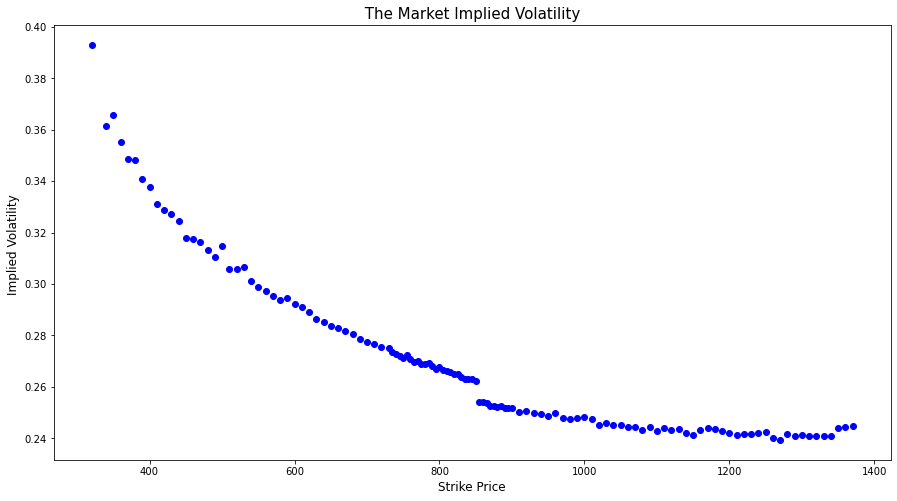

In [15]:
plt.figure(figsize = (15,8))
plt.scatter(df.iloc[:,0],df.iloc[:,2],color = 'blue')
plt.title(" The Market Implied Volatility ", fontsize = 15)
plt.xlabel('Strike Price',fontsize = 12)
plt.ylabel('Implied Volatility ',fontsize = 12)
plt.show()

### Displaced-diﬀusion model

The equation for the displaced-diffusion model:
$$ F_T=\frac{F_0}{\beta}e^{\beta\sigma W_T-\frac{\beta^2\sigma^2T}{2}}-\frac{1-\beta}{\beta}F_0 $$

Compare to the BS model：
$$ F_T=F_0e^{\sigma W_T-\frac{\sigma^2T}{2}}$$

The vanilla call option for BS is 
\begin{equation}
\begin{split}
C(S,K,r,\sigma,T) &= S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2)\\
            d_1 &= \frac{\log \frac{S_0}{K} +
            \left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}, \hspace{2cm} d_2 = d_1 - \sigma\sqrt{T}\\
\end{split}            
\end{equation}


If we denote BS call as $ C(F_0,K,r,\sigma,T)$ , the Displaced-diffusion call can be show as $ C(\frac{F_0}{\beta},  K+\frac{1-\beta}{\beta}F_0, r,\sigma\beta,T)$

Similarly, the Black-Scholes formula for a put option is given by

\begin{equation}
P(S,K,r,\sigma,T) = K e^{-rT} \Phi(-d_2) - S_0 \Phi(-d_1)
\end{equation}

The Displaced-diffusion put is $ P(\frac{F_0}{\beta},  K+\frac{1-\beta}{\beta}F_0, r,\sigma\beta,T)$

In [16]:
def Displaced_diffusionCall(F,K,r,sigma,T,beta):
    Fd = F / beta
    sigmad = sigma * beta
    Kd = K + (( 1 - beta ) / beta) * F
    d1 = (np.log(Fd / Kd) + (sigmad ** 2/2) * T) / (sigmad * np.sqrt(T))
    d2 = d1 - sigmad * np.sqrt(T)
    return np.exp(-r * T) * (Fd * norm.cdf(d1) - Kd * norm.cdf(d2))

In [17]:
def Displaced_diffusionPut(F,K,r,sigma,T,beta):
    Fd = F / beta
    sigmad = sigma * beta
    Kd = K + ((1-beta)/beta) * F
    d1 = (np.log(Fd/Kd)+(sigmad ** 2/2) * T) / (sigmad * np.sqrt(T))
    d2 = d1 - sigmad * np.sqrt(T)
    return np.exp(-r * T) * (Kd * norm.cdf(-d2) - Fd * norm.cdf(-d1))

In [18]:
K_closest=min(df['strike'],key=lambda x: abs(x-F))
K_closest

850

In [19]:
atm_call = (100+102.8)/2
atm_put = (101.8+104)/2
sigma_call = impliedCallVolatility(S, K_closest, r, atm_call, T)
sigma_put = impliedPutVolatility(S, K_closest, r, atm_put, T)
sigma_match = (sigma_call + sigma_put)/2
sigma_match

0.25827414878228977

In [20]:
def impliedvol_d_call(beta):
    impliedvolCall_diff=[]
    for i in range(len(imp_call)):
        price_diff_Call=Displaced_diffusionCall(F,imp_call.iloc[i,0],r,sigma_match,T,beta)
        impliedvol=impliedCallVolatility(S, imp_call.iloc[i,0], r, price_diff_Call, T)
        impliedvolCall_diff.append(impliedvol)
    return impliedvolCall_diff

In [21]:
impliedvol_diff_call = pd.DataFrame()
beta_diff = np.array([0.2,0.4,0.6,0.8,1.0])
for beta in beta_diff:
    c = pd.DataFrame(impliedvol_d_call(beta))
    impliedvol_diff_call = pd.concat([impliedvol_diff_call,c],axis = 1)
imp_call = imp_call.reset_index()
imp_call = imp_call.drop(['index'],axis = 1)
impliedvol_diff_call.columns = beta_diff
impliedvol_diff_call = pd.concat([imp_call,impliedvol_diff_call],axis = 1 )
impliedvol_diff_call.head()

,strike,mid,impliedVol,0.2,0.4,0.6,0.8,1.0
0,855,99.1,0.253962,0.258827,0.258809,0.258710,0.258532,0.258274
1,860,97.0,0.254079,0.258219,0.258353,0.258407,0.258381,0.258274
2,865,94.8,0.253846,0.257617,0.257902,0.258107,0.258231,0.258274
3,870,92.2,0.252510,0.257019,0.257454,0.257809,0.258082,0.258274
4,875,90.2,0.252596,0.256426,0.257011,0.257514,0.257935,0.258274


In [22]:
def impliedvol_d_put(beta):
    impliedvolPut_diff=[]
    for i in range(len(imp_put)):
        price_diff_Put=Displaced_diffusionPut(F,imp_put.iloc[i,0],r,sigma_match,T,beta)
        impliedvol=impliedPutVolatility(S, imp_put.iloc[i,0], r, price_diff_Put, T)
        impliedvolPut_diff.append(impliedvol)
    return impliedvolPut_diff

In [23]:
impliedvol_diff_put=pd.DataFrame()
beta_diff = np.array([0.2,0.4,0.6,0.8,1.0])
for beta in beta_diff:
    d = pd.DataFrame(impliedvol_d_put(beta))
    impliedvol_diff_put = pd.concat([impliedvol_diff_put,d],axis = 1)
impliedvol_diff_put.columns = beta_diff
impliedvol_diff_put = pd.concat([imp_put,impliedvol_diff_put],axis = 1 )
impliedvol_diff_put.tail()

,strike,mid,impliedVol,0.2,0.4,0.6,0.8,1.0
60,830,92.75,0.264003,0.261942,0.261146,0.260268,0.259311,0.258274
61,835,95.10,0.263234,0.261308,0.260670,0.259951,0.259152,0.258274
62,840,97.70,0.263015,0.260680,0.260199,0.259636,0.258995,0.258274
63,845,100.40,0.262956,0.260057,0.259731,0.259325,0.258839,0.258274
64,850,102.90,0.262292,0.259440,0.259268,0.259016,0.258685,0.258274


In [24]:
impliedvol_diff = pd.concat([impliedvol_diff_put,impliedvol_diff_call],axis = 0 )
impliedvol_diff.head()

,strike,mid,impliedVol,0.2,0.4,0.6,0.8,1.0
0,320,1.450,0.393102,0.382252,0.354314,0.324730,0.293003,0.258274
1,340,1.225,0.361520,0.373432,0.347321,0.319742,0.290289,0.258274
2,350,1.625,0.365782,0.369270,0.344029,0.317402,0.289021,0.258274
3,360,1.625,0.355104,0.365260,0.340861,0.315155,0.287808,0.258274
4,370,1.750,0.348660,0.361392,0.337810,0.312995,0.286645,0.258274


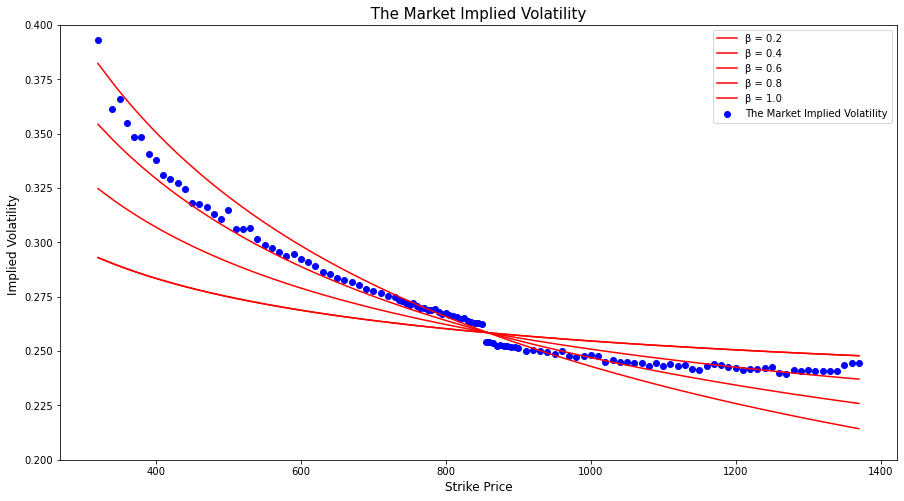

In [25]:
plt.figure(figsize = (15,8))
plt.scatter(df.iloc[:,0],df.iloc[:,2],color = 'blue',label = 'The Market Implied Volatility')
plt.plot(impliedvol_diff.iloc[:,0],impliedvol_diff.iloc[:,3],color = 'red',label = 'β = 0.2')
plt.plot(impliedvol_diff.iloc[:,0],impliedvol_diff.iloc[:,4],color = 'red',label = 'β = 0.4')
plt.plot(impliedvol_diff.iloc[:,0],impliedvol_diff.iloc[:,5],color = 'red',label = 'β = 0.6')
plt.plot(impliedvol_diff.iloc[:,0],impliedvol_diff.iloc[:,6],color = 'red',label = 'β = 0.8')
plt.plot(impliedvol_diff.iloc[:,0],impliedvol_diff.iloc[:,6],color = 'red',label = 'β = 1.0')
plt.title(" The Market Implied Volatility ", fontsize = 15)
plt.xlabel('Strike Price',fontsize = 12)
plt.ylabel('Implied Volatility ',fontsize = 12)
plt.ylim(0.2,0.4)
plt.legend()
plt.show()

In [26]:
def ddmcalibration(x,strikes,vols,F,T,S,sigma_match):
    impliedvolCall_diff=[]
    for i in range(len(imp_call)):
        price_diff_Call=Displaced_diffusionCall(F,imp_call.iloc[i,0],r,sigma_match,T,x)
        impliedvol=impliedCallVolatility(S, imp_call.iloc[i,0], r, price_diff_Call, T)
        impliedvolCall_diff.append(impliedvol)
        
    impliedvolPut_diff=[]
    for i in range(len(imp_put)):
        price_diff_Put=Displaced_diffusionPut(F,imp_put.iloc[i,0],r,sigma_match,T,x)
        impliedvol=impliedPutVolatility(S, imp_put.iloc[i,0], r, price_diff_Put, T)
        impliedvolPut_diff.append(impliedvol)
    impliedvol_diffi = np.array(impliedvolPut_diff + impliedvolCall_diff)
    
    err=0.0
    for i, vol in enumerate(vols):
        err += (vol - impliedvol_diffi[i])**2

    return err

res2 = least_squares(lambda x: ddmcalibration(x,df['strike'],df['impliedVol'],F,T,S,sigma_match),0.1)

beta_exact=res2.x[0]
print('beta_exact',beta_exact)

beta_exact 0.36577152504382965


In [27]:
cc = pd.DataFrame(impliedvol_d_call(beta_exact))
dd = pd.DataFrame(impliedvol_d_put(beta_exact))
ee = pd.concat([dd,cc],axis = 0 )
ee = ee.reset_index()
ee = ee.drop(['index'],axis = 1)
ee

,0
0,0.359202
1,0.351885
2,0.348439
3,0.345122
4,0.341927
...,...
117,0.225920
118,0.225422
119,0.224931
120,0.224444


In [29]:
impliedvol_diff = impliedvol_diff.reset_index()
impliedvol_diff = impliedvol_diff.drop(['index'],axis = 1)
impliedvol_diff = pd.concat([impliedvol_diff,ee],axis = 1 )
impliedvol_diff

,strike,mid,impliedVol,0.2,0.4,0.6,0.8,1.0,0
0,320,1.450,0.393102,0.382252,0.354314,0.324730,0.293003,0.258274,0.359202
1,340,1.225,0.361520,0.373432,0.347321,0.319742,0.290289,0.258274,0.351885
2,350,1.625,0.365782,0.369270,0.344029,0.317402,0.289021,0.258274,0.348439
3,360,1.625,0.355104,0.365260,0.340861,0.315155,0.287808,0.258274,0.345122
4,370,1.750,0.348660,0.361392,0.337810,0.312995,0.286645,0.258274,0.341927
...,...,...,...,...,...,...,...,...,...
117,1330,7.350,0.240758,0.216835,0.227760,0.238290,0.248453,0.258274,0.225920
118,1340,6.950,0.240881,0.216192,0.227292,0.237986,0.248305,0.258274,0.225422
119,1350,6.950,0.243821,0.215557,0.226829,0.237685,0.248158,0.258274,0.224931
120,1360,6.650,0.244487,0.214928,0.226371,0.237388,0.248013,0.258274,0.224444


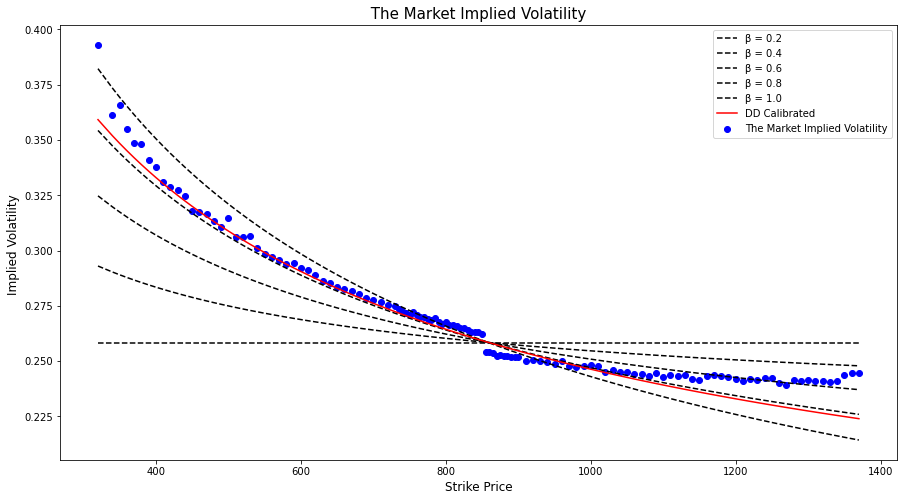

In [30]:
plt.figure(figsize = (15,8))
plt.scatter(df.iloc[:,0],df.iloc[:,2],color = 'blue',label = 'The Market Implied Volatility')
plt.plot(impliedvol_diff.iloc[:,0],impliedvol_diff.iloc[:,3],color = 'black',linestyle = '--',label = 'β = 0.2')
plt.plot(impliedvol_diff.iloc[:,0],impliedvol_diff.iloc[:,4],color = 'black',linestyle = '--',label = 'β = 0.4')
plt.plot(impliedvol_diff.iloc[:,0],impliedvol_diff.iloc[:,5],color = 'black',linestyle = '--',label = 'β = 0.6')
plt.plot(impliedvol_diff.iloc[:,0],impliedvol_diff.iloc[:,6],color = 'black',linestyle = '--',label = 'β = 0.8')
plt.plot(impliedvol_diff.iloc[:,0],impliedvol_diff.iloc[:,7],color = 'black',linestyle = '--',label = 'β = 1.0')
plt.plot(impliedvol_diff.iloc[:,0],impliedvol_diff.iloc[:,8],color = 'red',label = 'DD Calibrated')
plt.title(" The Market Implied Volatility ", fontsize = 15)
plt.xlabel('Strike Price',fontsize = 12)
plt.ylabel('Implied Volatility ',fontsize = 12)
plt.legend()
plt.show()

###  SABR model (ﬁx β = 0.8)

First, we shall implement the SABR model. The implied Black volatility of the SABR model is given by
  \begin{equation*}
    \begin{split}
      &\sigma_{\mbox{SABR}}(F_0, K, \alpha, \beta, \rho, \nu) \\
      &= \frac{\alpha}{(F_0K)^{(1-\beta)/2}\left\{ 1 + \frac{(1-\beta)^2}{24}\log^2\left(\frac{F_0}{K}\right) + \frac{(1-\beta)^4}{1920}\log^4\left(\frac{F_0}{K}\right) + \cdots\right\} } \\
      &\;\;\;\times \frac{z}{x(z)} \times \left\{ 1 + \left[
          \frac{(1-\beta)^2}{24}
          \frac{\alpha^2}{(F_0K)^{1-\beta}}+\frac{1}{4}\frac{\rho\beta\nu\alpha}{(F_0K)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}\nu^2\right]
        T + \cdots \right.
    \end{split}
  \end{equation*}
  
  where
  \begin{equation*}
    \begin{split}
      z = \frac{\nu}{\alpha} (F_0K)^{(1-\beta)/2}
      \log\left(\frac{F_0}{K}\right),
    \end{split}
  \end{equation*}
  and
  \begin{equation*}
    \begin{split}
      x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2}+z -\rho}{1-\rho}
      \right].
    \end{split}
  \end{equation*}


This can be implemented in Python as follows:

In [31]:
beta = 0.8

In [32]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))* np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [33]:
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

In [34]:
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df['strike'],
                                              df['impliedVol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 0.991, beta = 0.8, rho = -0.285, nu = 0.352


In [35]:
Vol_SABR=[]
for K in df['strike']:
    sabrvoli=SABR(F, K, T, alpha, beta, rho, nu)
    Vol_SABR.append(sabrvoli)

In [36]:
df['Vol_SABR'] = Vol_SABR
df

,strike,mid,impliedVol,Vol_SABR
0,320,1.450,0.393102,0.368805
1,340,1.225,0.361520,0.361070
2,350,1.625,0.365782,0.357384
3,360,1.625,0.355104,0.353810
4,370,1.750,0.348660,0.350344
...,...,...,...,...
117,1330,7.350,0.240758,0.241277
118,1340,6.950,0.240881,0.241287
119,1350,6.950,0.243821,0.241307
120,1360,6.650,0.244487,0.241335


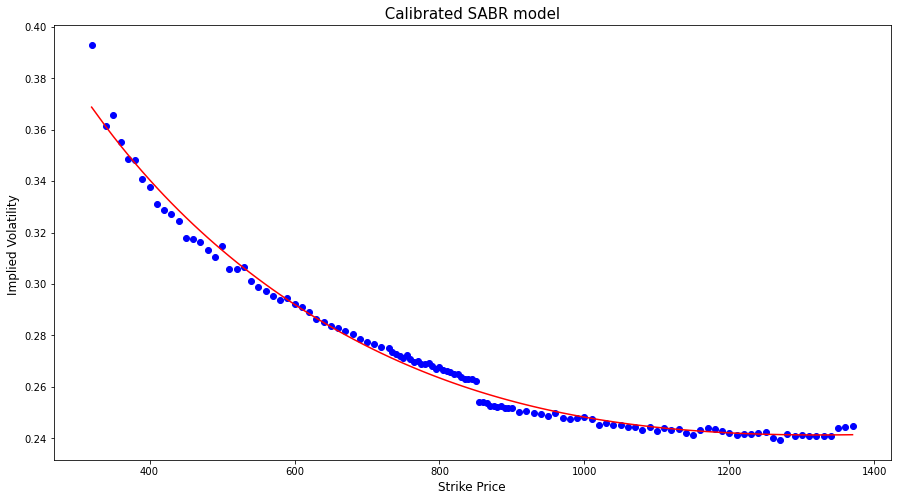

In [37]:
plt.figure(figsize = (15,8))
plt.plot(df.strike,df.Vol_SABR,color = 'red')
plt.scatter(df.iloc[:,0],df.iloc[:,2],color = 'blue')
plt.title(" Calibrated SABR model ", fontsize = 15)
plt.xlabel('Strike Price',fontsize = 12)
plt.ylabel('Implied Volatility ',fontsize = 12)
plt.show()

In [38]:
def A(i):
    Vol_SABR_Alpha=[]
    for K in df['strike']:
        sabrvoli_1=SABR(F, K, T, i, beta, rho, nu)
        Vol_SABR_Alpha.append(sabrvoli_1)
    Vol_SABR_Alpha = pd.DataFrame(Vol_SABR_Alpha)
    return Vol_SABR_Alpha

In [39]:
df_alpha = df
alpha_1 = np.arange(0.6,1.6,0.2)
for i in [0.6,0.8,1,1.2,1.4]:
    AA = A(i)
    df_alpha = pd.concat([df_alpha,AA],axis =1 )
df_alpha

,strike,mid,impliedVol,Vol_SABR,0,0,0,0,0
0,320,1.450,0.393102,0.368805,0.264116,0.317702,0.371279,0.425036,0.479000
1,340,1.225,0.361520,0.361070,0.256889,0.310176,0.363535,0.417112,0.470908
2,350,1.625,0.365782,0.357384,0.253430,0.306583,0.359845,0.413341,0.467060
3,360,1.625,0.355104,0.353810,0.250066,0.303095,0.356268,0.409688,0.463336
4,370,1.750,0.348660,0.350344,0.246794,0.299707,0.352798,0.406148,0.459728
...,...,...,...,...,...,...,...,...,...
117,1330,7.350,0.240758,0.241277,0.153929,0.197769,0.243409,0.290127,0.337482
118,1340,6.950,0.240881,0.241287,0.154263,0.197925,0.243413,0.290005,0.337256
119,1350,6.950,0.243821,0.241307,0.154604,0.198089,0.243426,0.289893,0.337039
120,1360,6.650,0.244487,0.241335,0.154949,0.198261,0.243448,0.289789,0.336831


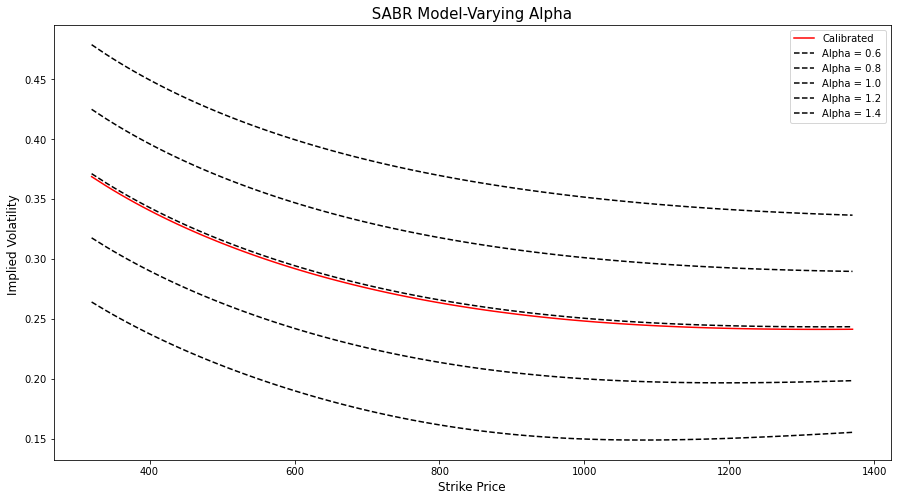

In [40]:
plt.figure(figsize = (15,8))
plt.plot(df_alpha.iloc[:,0],df_alpha.iloc[:,3],color = 'red',label = 'Calibrated')
plt.plot(df_alpha.iloc[:,0],df_alpha.iloc[:,4],color = 'black',linestyle = '--',label = 'Alpha = 0.6')
plt.plot(df_alpha.iloc[:,0],df_alpha.iloc[:,5],color = 'black',linestyle = '--',label = 'Alpha = 0.8')
plt.plot(df_alpha.iloc[:,0],df_alpha.iloc[:,6],color = 'black',linestyle = '--',label = 'Alpha = 1.0')
plt.plot(df_alpha.iloc[:,0],df_alpha.iloc[:,7],color = 'black',linestyle = '--',label = 'Alpha = 1.2')
plt.plot(df_alpha.iloc[:,0],df_alpha.iloc[:,8],color = 'black',linestyle = '--',label = 'Alpha = 1.4')
plt.title(" SABR Model-Varying Alpha ", fontsize = 15)
plt.xlabel('Strike Price',fontsize = 12)
plt.ylabel('Implied Volatility ',fontsize = 12)
plt.legend()
plt.show()

In [41]:
def R(i):
    Vol_SABR_rho=[]
    for K in df['strike']:
        sabrvoli_2=SABR(F, K, T, alpha, beta, i, nu)
        Vol_SABR_rho.append(sabrvoli_2)
    Vol_SABR_rho = pd.DataFrame(Vol_SABR_rho)
    return Vol_SABR_rho

In [42]:
df_rho = df
for i in [-0.9,-0.6,-0.3,0,0.3]:
    BB = R(float(i))
    df_rho = pd.concat([df_rho,BB],axis =1 )
df_rho

,strike,mid,impliedVol,Vol_SABR,0,0,0,0,0
0,320,1.450,0.393102,0.368805,0.412424,0.393893,0.370131,0.340208,0.302192
1,340,1.225,0.361520,0.361070,0.402983,0.385191,0.362346,0.333553,0.296960
2,350,1.625,0.365782,0.357384,0.398447,0.381024,0.358635,0.330405,0.294524
3,360,1.625,0.355104,0.353810,0.394027,0.376971,0.355036,0.327369,0.292203
4,370,1.750,0.348660,0.350344,0.389714,0.373025,0.351544,0.324440,0.289990
...,...,...,...,...,...,...,...,...,...
117,1330,7.350,0.240758,0.241277,0.169367,0.210021,0.239952,0.264577,0.285503
118,1340,6.950,0.240881,0.241287,0.168085,0.209593,0.239946,0.264868,0.286031
119,1350,6.950,0.243821,0.241307,0.166823,0.209180,0.239949,0.265163,0.286557
120,1360,6.650,0.244487,0.241335,0.165582,0.208784,0.239961,0.265462,0.287082


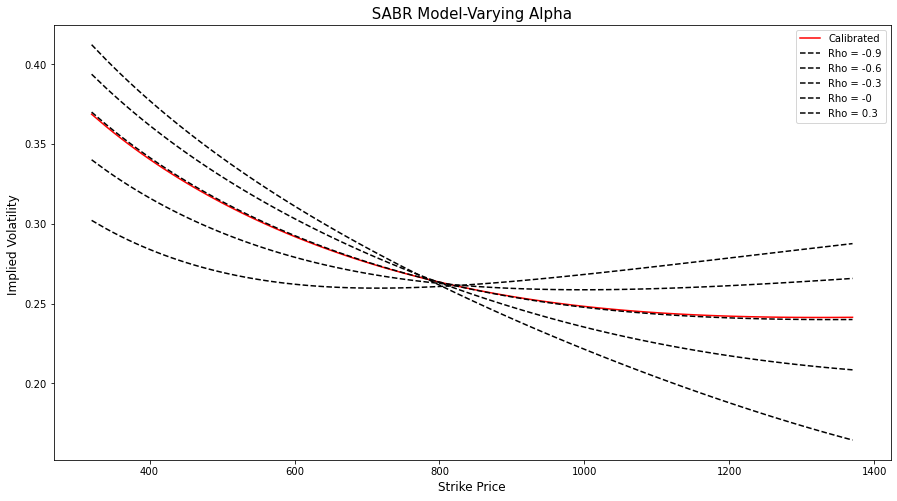

In [43]:
plt.figure(figsize = (15,8))
plt.plot(df_rho.iloc[:,0],df_rho.iloc[:,3],color = 'red',label = 'Calibrated')
plt.plot(df_rho.iloc[:,0],df_rho.iloc[:,4],color = 'black',linestyle = '--',label = 'Rho = -0.9')
plt.plot(df_rho.iloc[:,0],df_rho.iloc[:,5],color = 'black',linestyle = '--',label = 'Rho = -0.6')
plt.plot(df_rho.iloc[:,0],df_rho.iloc[:,6],color = 'black',linestyle = '--',label = 'Rho = -0.3')
plt.plot(df_rho.iloc[:,0],df_rho.iloc[:,7],color = 'black',linestyle = '--',label = 'Rho = -0')
plt.plot(df_rho.iloc[:,0],df_rho.iloc[:,8],color = 'black',linestyle = '--',label = 'Rho = 0.3')
plt.title(" SABR Model-Varying Alpha ", fontsize = 15)
plt.xlabel('Strike Price',fontsize = 12)
plt.ylabel('Implied Volatility ',fontsize = 12)
plt.legend()
plt.show()

In [44]:
def N(i):
    Vol_SABR_nu=[]
    for K in df['strike']:
        sabrvoli_3=SABR(F, K, T, alpha, beta, rho, i)
        Vol_SABR_nu.append(sabrvoli_3)
    Vol_SABR_nu = pd.DataFrame(Vol_SABR_nu)
    return Vol_SABR_nu

In [45]:
df_nu = df
nu_1 = np.arange(-0.2,1.3,0.3)
for i in nu_1:
    CC = N(i)
    df_nu = pd.concat([df_nu,CC],axis =1 )
df_nu

,strike,mid,impliedVol,Vol_SABR,0,0,0,0,0
0,320,1.450,0.393102,0.368805,0.279769,0.300857,0.383451,0.482385,0.593422
1,340,1.225,0.361520,0.361070,0.277272,0.297892,0.374797,0.468115,0.573490
2,350,1.625,0.365782,0.357384,0.276123,0.296483,0.370669,0.461274,0.563913
3,360,1.625,0.355104,0.353810,0.275037,0.295120,0.366663,0.454616,0.554578
4,370,1.750,0.348660,0.350344,0.274008,0.293799,0.362775,0.448132,0.545472
...,...,...,...,...,...,...,...,...,...
117,1330,7.350,0.240758,0.241277,0.264584,0.240420,0.243648,0.270782,0.313196
118,1340,6.950,0.240881,0.241287,0.264739,0.240171,0.243760,0.271659,0.314874
119,1350,6.950,0.243821,0.241307,0.264895,0.239926,0.243881,0.272542,0.316550
120,1360,6.650,0.244487,0.241335,0.265051,0.239683,0.244011,0.273432,0.318221


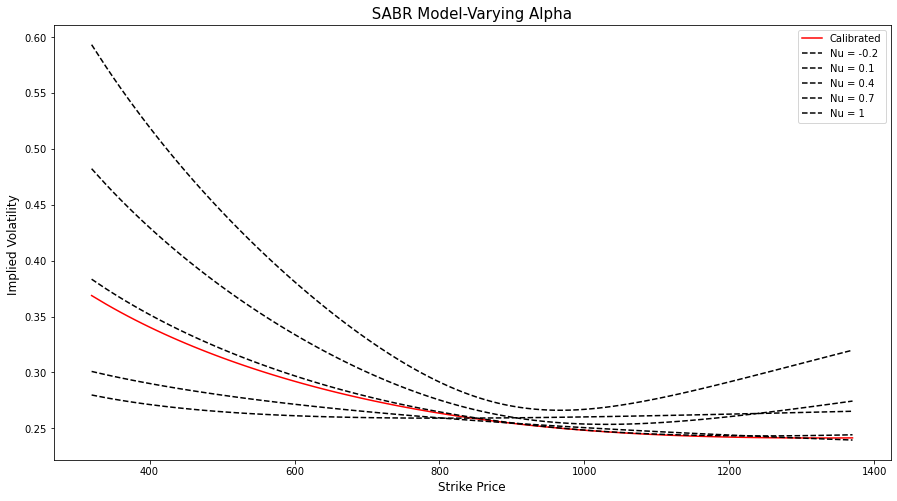

In [46]:
plt.figure(figsize = (15,8))
plt.plot(df_nu.iloc[:,0],df_nu.iloc[:,3],color = 'red',label = 'Calibrated')
plt.plot(df_nu.iloc[:,0],df_nu.iloc[:,4],color = 'black',linestyle = '--',label = 'Nu = -0.2')
plt.plot(df_nu.iloc[:,0],df_nu.iloc[:,5],color = 'black',linestyle = '--',label = 'Nu = 0.1')
plt.plot(df_nu.iloc[:,0],df_nu.iloc[:,6],color = 'black',linestyle = '--',label = 'Nu = 0.4')
plt.plot(df_nu.iloc[:,0],df_nu.iloc[:,7],color = 'black',linestyle = '--',label = 'Nu = 0.7')
plt.plot(df_nu.iloc[:,0],df_nu.iloc[:,8],color = 'black',linestyle = '--',label = 'Nu = 1')
plt.title(" SABR Model-Varying Alpha ", fontsize = 15)
plt.xlabel('Strike Price',fontsize = 12)
plt.ylabel('Implied Volatility ',fontsize = 12)
plt.legend()
plt.show()